# Exploración de Datos

## California Housing prices
Vamos a utilizar los datos de un censo de California para construir un modelo de precios de viviendas del estado. 
Estos datos incluyen métricas como la población, el ingreso medio y el precio medio de las viviendas para cada grupo de bloques en California. Los grupos de bloques son la unidad geográfica más pequeña para la cual la Oficina del Censo de los Estados Unidos publica datos (un grupo de bloques típicamente tiene una población de 600 a 3,000 personas). Podemos referirnos a ellos como "distritos" de manera abreviada. El modelo debe aprender de estos datos y ser capaz de predecir el precio medio de las viviendas en cualquier distrito, dado el resto de las métricas.

## Data pipeline

Una secuencia de componentes de procesamiento de datos se llama flujo de datos, _data pipeline_ o simplemente _pipeline_. Los _pipelines_ son muy comunes en sistemas de aprendizaje maquinal, ya que hay muchos datos para manipular y muchas transformaciones de datos que aplicar. 

Nosotros vamos a utilizar un _pipeline_ para transformar los datos, aplicar algún algoritmo de aprendizaje maquinal (modelo) y evaluar posteriormente dicho algoritmo. 

**¿Qué tipo de entrenamiento necesitamos para nuestro modelo? ¿Qué tarea se va a realizar?**

Esto es claramente una tarea típica de `aprendizaje supervisado`, ya que el modelo puede ser entrenado con datos etiquetados (cada instancia viene con la salida esperada, es decir, el precio medio de las viviendas del distrito). Es una tarea de _regresión_ típica, ya que el modelo predice un valor. Más específicamente, se trata de un problema de _regresión múltiple_, porque el sistema utilizará múltiples características para hacer una predicción (la población del distrito, el ingreso medio, etc.). También es un problema de _regresión univariada_, ya que solo tratamos de predecir un único valor para cada distrito. Si quisieramos predecir múltiples valores por distrito, sería un problema de _regresión multivariada_.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Cargamos los datos

In [32]:
df_housing = pd.read_csv("./data/housing.csv")
df_housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Cada fila representa un distrito. La tabla tiene 10 atributos: longitud, latitud, mediana de la edad de viviendas, total de habitaciones, total de dormitorios, población, hogares, mediana del ingreso, mediana del valor de la vivienda y proximidad al océano.

**Para conocer los atributos existentes y el número de instancias pertenecientes a cada atributo**

In [33]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Hay 20,640 instancias en el conjunto de datos. El atributo total_bedrooms solo tiene 20,433 valores no nulos, significa que faltan 207 distritos en este atributo. Necesitaremos ocuparnos de esto más adelante. Todos los atributos son numéricos, excepto `ocean_proximity`. Su tipo de dato es `object`, por lo que podría contener cualquier tipo de dato de Python. Pero al cargar los datos desde un archivo CSV, sabemos que debe ser texto. Al observar las cinco primeras filas, notamos que los valores en la columna ocean_proximity son repetitivos, lo que sugiere que probablemente es un _atributo categórico_.

**Para conocer las categorias existentes y el número de instancias pertenecientes a cada categoría**

In [34]:
df_housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

**describe() muestra un resumen de los atributos numéricos**

In [35]:
df_housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


**Un percentil indica el valor por debajo del cual cae un cierto porcentaje de observaciones o instancias en un grupo de observaciones.**

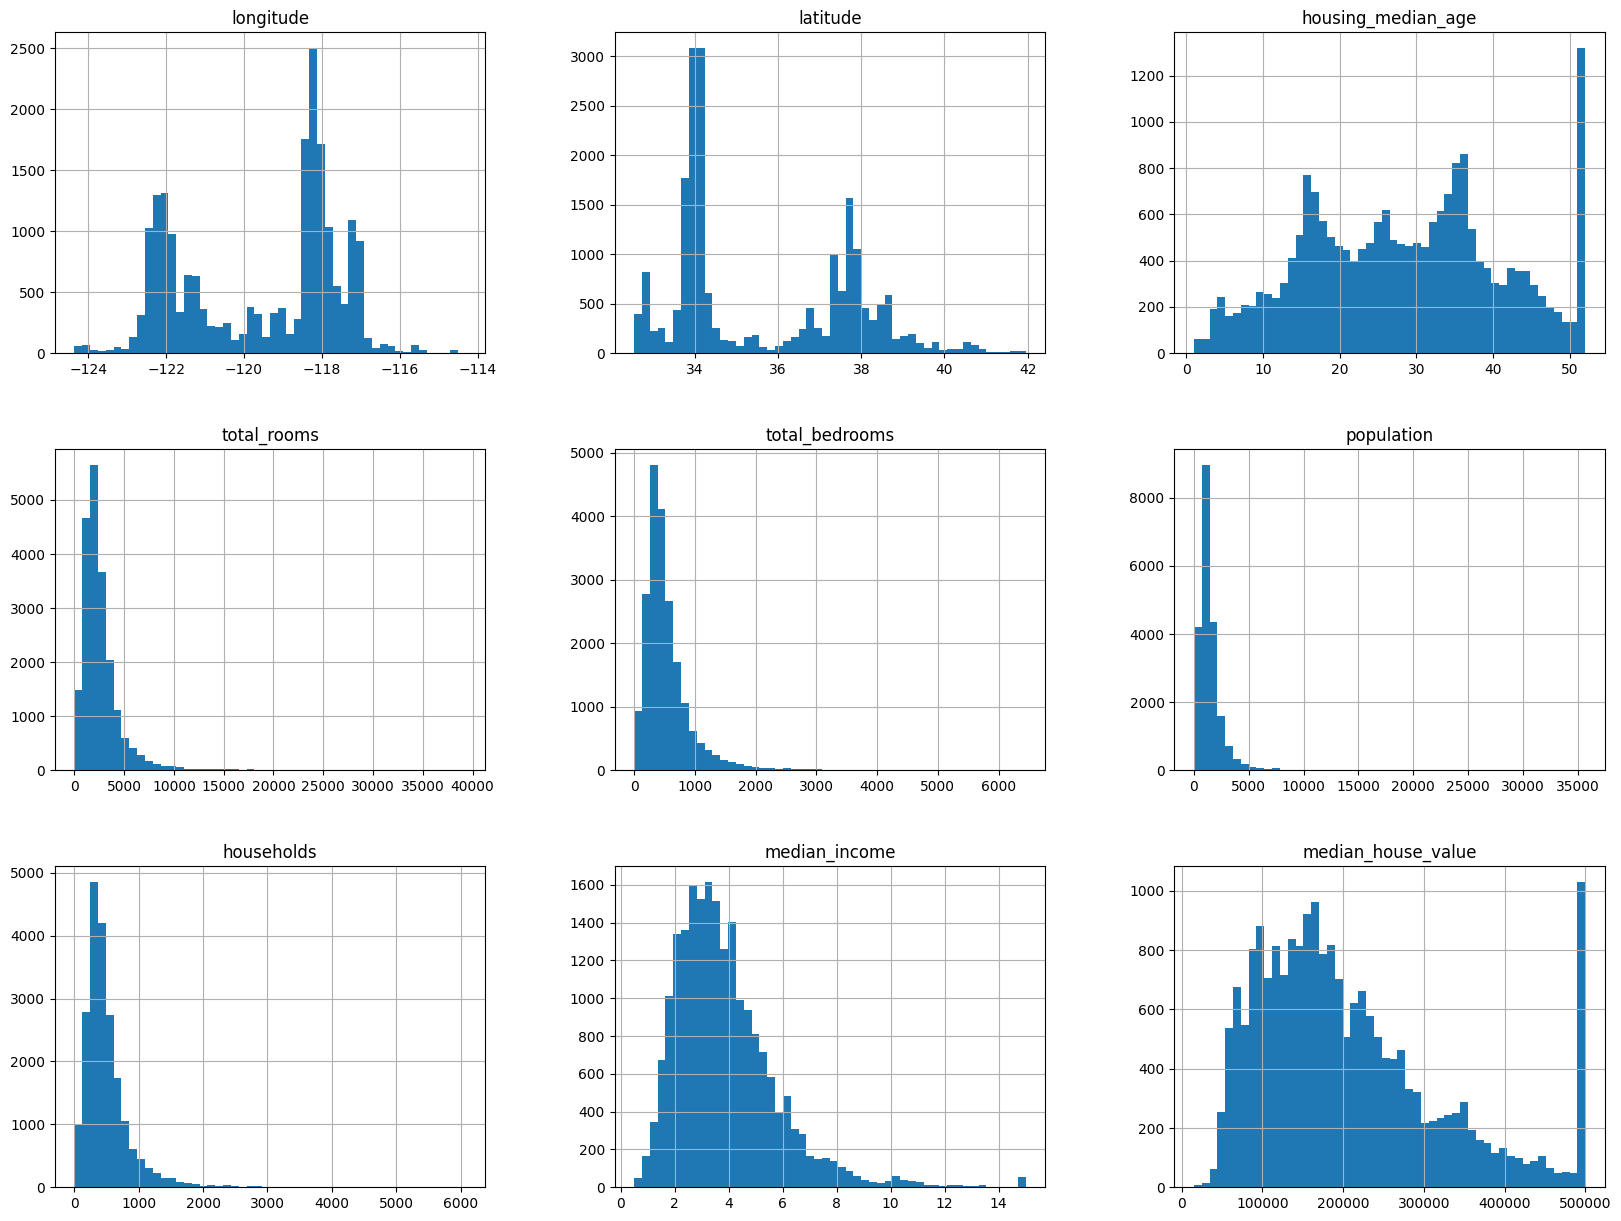

In [36]:
df_housing.hist(bins=50, figsize=(20,15))
plt.show()

- El atributo de `median_income` no parece estar expresado en USD. Después de verificar, informan que los datos se han escalado y limitado a 15 para `median_income` altos, y a 0.5 para `median income` más bajos. Los números representan aproximadamente decenas de miles de dólares (por ejemplo, 3 en realidad significa alrededor de $30,000). Trabajar con atributos preprocesados es común en aprendizaje automático, y no necesariamente es un problema, pero se debe comprender cómo se calcularon los datos.
- Los atributos `housing_median_age` y `median_house_value` también fueron limitados. Este último podría ser un problema grave ya que es tu atributo objetivo o _target_ (etiquetas). El algoritmo de aprendizaje automático podría aprender que los precios nunca superan ese límite. Si nuestro cliente nos dice que necesita predicciones precisas incluso más allá de $500,000, entonces tenemos dos opciones:
    - Recopilar etiquetas adecuadas para los distritos cuyas etiquetas fueron limitadas.
    - Eliminar esos distritos del conjunto de datos.
- Algunos histogramas están sesgados hacia la derecha: se extienden mucho más hacia la derecha de la mediana que hacia la izquierda. Esto puede dificultar un poco la detección de patrones para algunos algoritmos de aprendizaje maquinal.

## Advertencia ⚠️

Antes de continuar observando los datos, vamos a separar un conjunto de prueba y no lo miramos más!!!

Si se observa el conjunto de prueba, es posible encontrar algun patrón interesante en los datos que nos lleve a seleccionar un tipo particular de modelo de aprendizaje maquinal. Al evaluar el modelo utilizando el conjunto de prueba, la estimación será demasiado optimista y el sistema no funcionará tan bien como se espera. A esto se llama sesgo de búsqueda de datos (data snooping bias).

## Creamos un conjunto de prueba

**¿Qué es un muetreo estratificado?**

Supongamos que conversamos con expertos que nos dicen que el `median_income` es un atributo muy importante para predecir la mediana de precios de las viviendas. Debemos asegurar que el conjunto de prueba sea representativo de las categorías de ingresos en el conjunto de datos. Dado que el `median_income` es un atributo numérico continuo, primero necesitamos crear un atributo de categoría de ingresos `income_cat`.

Vamos a observar más de cerca el histograma de `median_income`: 

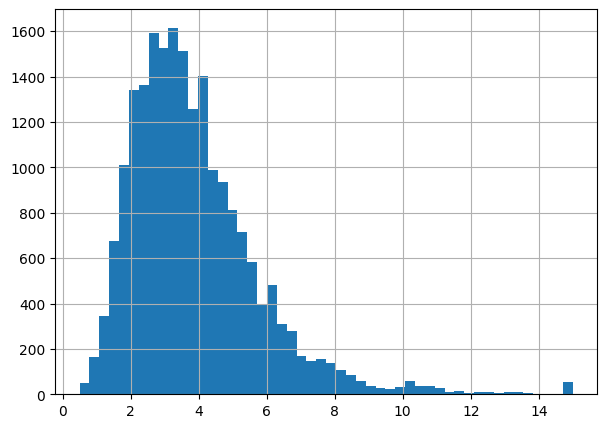

In [37]:
_ = df_housing["median_income"].hist(bins=50, figsize=(7,5))

la mayoría de los valores de ingresos se agrupan alrededor de 1.5 a 6 (es decir, $15,000 - $60,000), pero algunos van mucho más allá de 6. Es importante tener un número suficiente de instancias en tu conjunto de datos para cada estrato o categoría, o de lo contrario la estimación de la importancia de un estrato podría estar sesgada. Esto significa que no debemos tener demasiados estratos, y cada estrato debe ser lo suficientemente grande.

El siguiente código utiliza la función `pd.cut()` para crear un atributo `income_cat` con cinco categorías (etiquetadas del 1 al 5), la categoría 1 abarca desde 0 hasta 1.5 (es decir, menos de $15,000), la categoría 2 desde 1.5 hasta 3, y así sucesivamente:

In [38]:
df_housing["income_cat"] = pd.cut(df_housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
df_housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


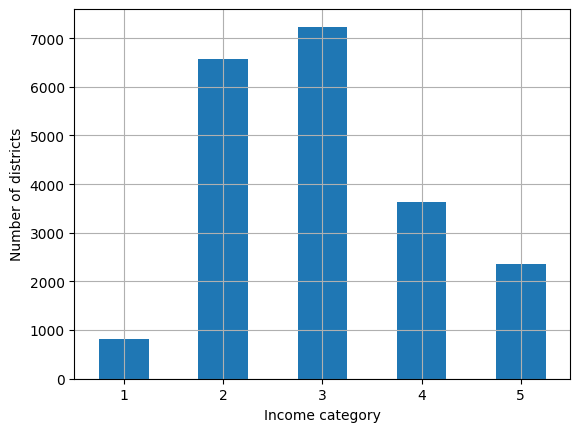

In [39]:
df_housing["income_cat"].value_counts().sort_index().plot.bar(rot=0)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
_ = plt.grid()

Ahora podemos hacer un muestreo estratificado con la categoría `income_cat`

In [40]:
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(df_housing, test_size=0.2, stratify=df_housing["income_cat"], random_state=42)

In [41]:
# Eliminamos la categoria income_cat de ambos conjuntos porque no la usamos más
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Visualización del conjunto de entrenamiento

In [42]:
# Antes de continuar hacemos una copia del conjunto de entrenamiento
housing = strat_train_set.copy()

### Visualización geográfica

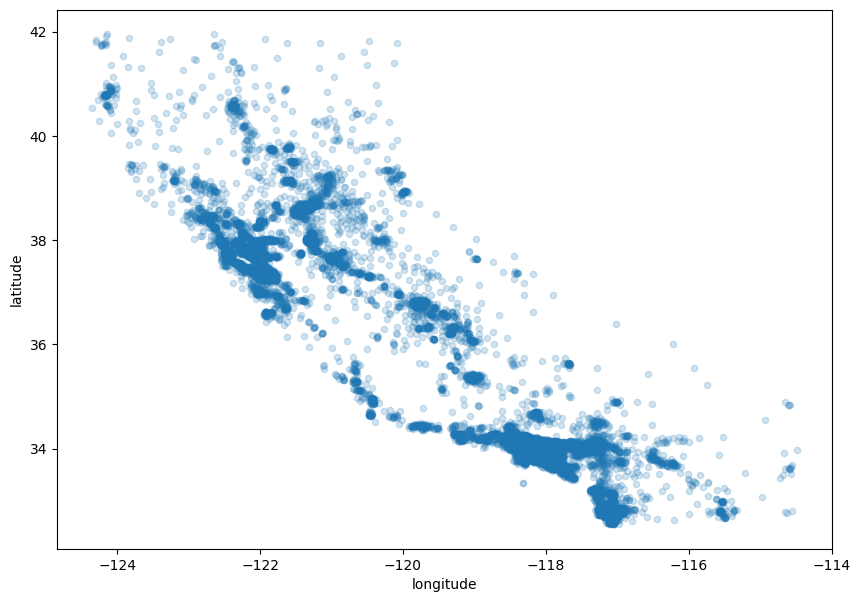

In [43]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha=0.2, figsize=(10,7))
plt.show()

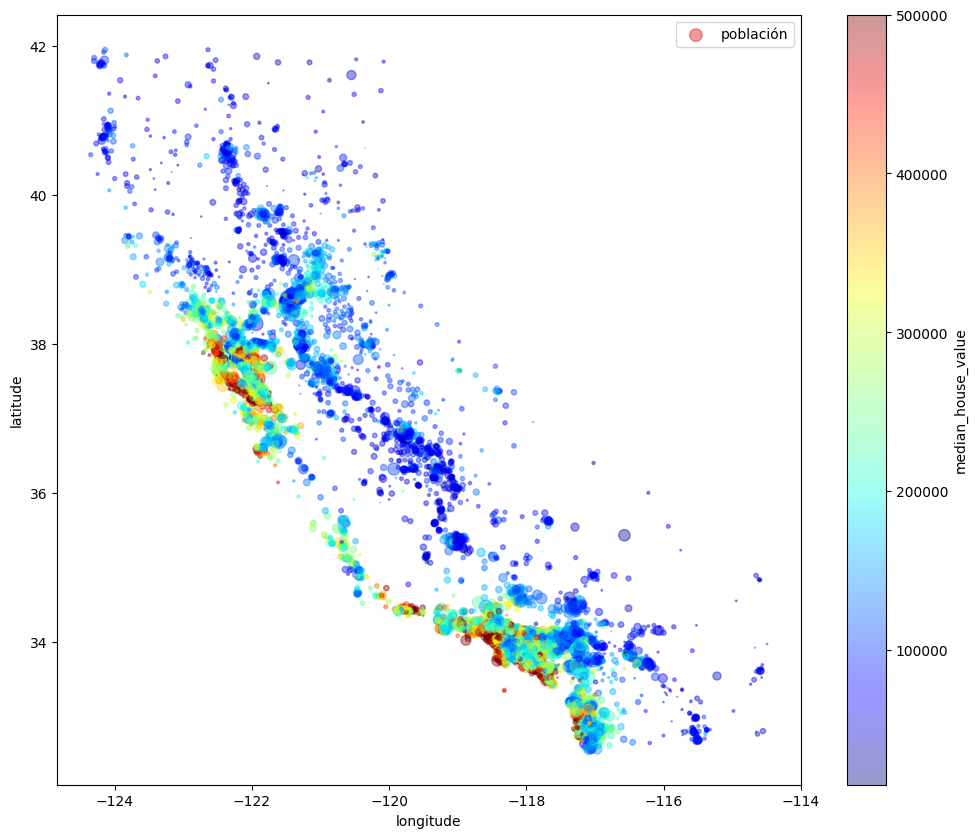

In [44]:
housing.plot(kind="scatter", x = "longitude", y = "latitude", alpha=0.4, 
              s = housing["population"]/100 , label="población", c="median_house_value",
              cmap="jet", colorbar = True, legend = True, sharex = False, figsize=(12,10))
plt.show()

Esta imagen indica que los precios de las viviendas están muy relacionados con la ubicación (por ejemplo, cerca del océano) y con la densidad de población.

### Correlaciones

Podemos calcular facilmente el _índice de correlación de Pearson_ entre cada par de atributos.

In [45]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924213,-0.102937,0.044558,0.068210,0.104236,0.054261,-0.016542,-0.050859
latitude,-0.924213,1.000000,0.005692,-0.036753,-0.066391,-0.115677,-0.071604,-0.078137,-0.139584
housing_median_age,-0.102937,0.005692,1.000000,-0.361710,-0.317978,-0.301906,-0.300075,-0.127043,0.102175
total_rooms,0.044558,-0.036753,-0.361710,1.000000,0.930076,0.863967,0.916143,0.197720,0.137455
total_bedrooms,0.068210,-0.066391,-0.317978,0.930076,1.000000,0.886200,0.978822,-0.006038,0.054635
population,0.104236,-0.115677,-0.301906,0.863967,0.886200,1.000000,0.916237,0.004282,-0.020153
households,0.054261,-0.071604,-0.300075,0.916143,0.978822,0.916237,1.000000,0.013637,0.071426
median_income,-0.016542,-0.078137,-0.127043,0.197720,-0.006038,0.004282,0.013637,1.000000,0.688380
median_house_value,-0.050859,-0.139584,0.102175,0.137455,0.054635,-0.020153,0.071426,0.688380,1.000000


Y la correlación de cada atributo con `median_house_value`

In [46]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

El coeficiente de correlación varía de -1 a 1. Cuando está cerca de 1, significa que hay una fuerte correlación positiva; por ejemplo, el `median_house_value` tiende a aumentar cuando el `median_income` aumenta. Cuando el coeficiente está cerca de -1, significa que hay una fuerte correlación negativa; se puede observar una pequeña correlación negativa entre la latitud y el `median_house_value` (es decir, los precios tienen una ligera tendencia a disminuir cuando nos dirigimos al norte). Finalmente, los coeficientes cercanos a 0 significan que no hay una correlación lineal.

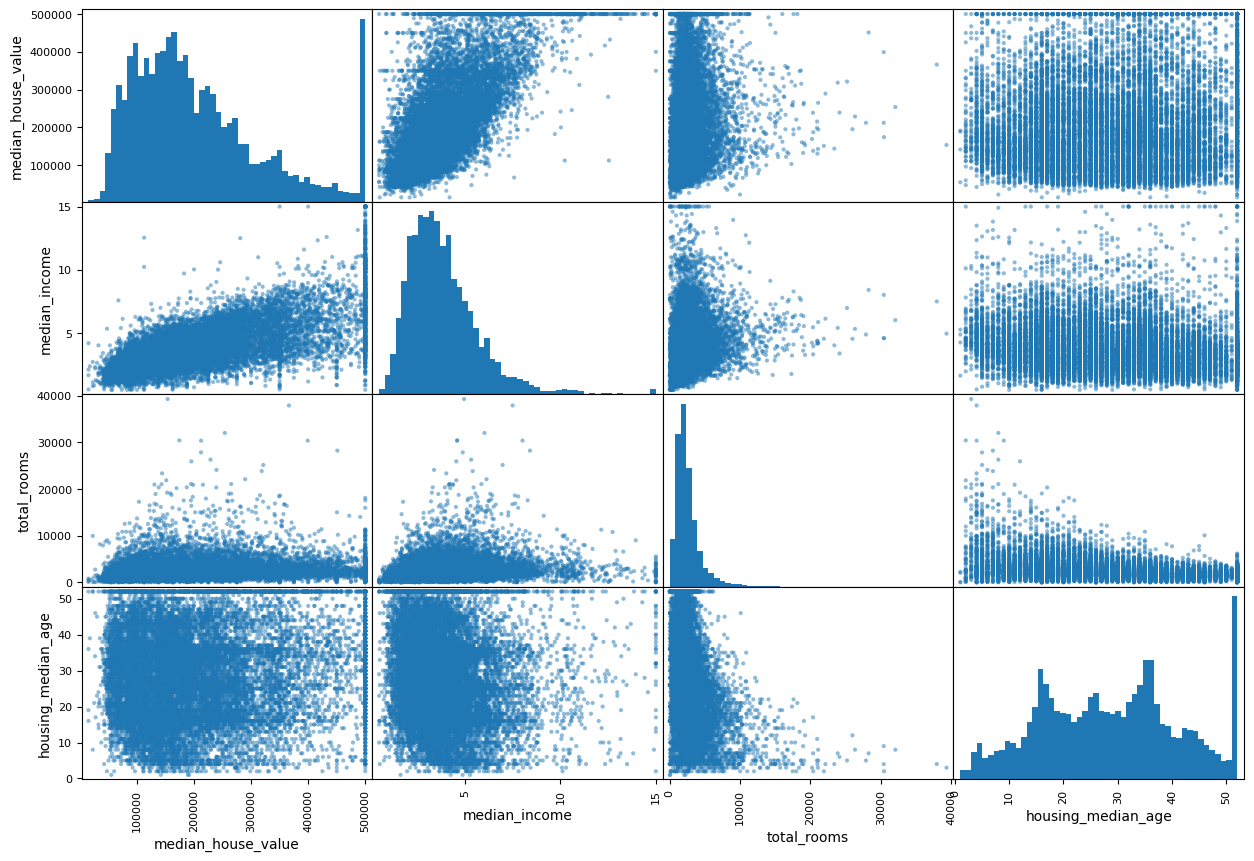

In [47]:
from pandas.plotting import scatter_matrix

atributos = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[atributos], figsize=(15,10), hist_kwds={'bins':50})
plt.show()

## Resumen de la primera parte: Exploración de los datos

En esta primera parte:
- Obtuvimos los datos
- Hicimos una exploración inicial para determinar:
    - número de instancias
    - número de atributos
    - tipos de datos de los atributos
    - si hay datos faltantes
- Dividimos los datos en conjuntos de entrenamiento y prueba. La división se hizo de forma estratificada en función de un atributo definido por expertos.
- Exploramos más en profundidad el conjunto de entrenamiento mediante visualizaciones, búsqueda de atributos correlacionados.
